In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

import re

# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('lead1', help='lead')
# parser.add_argument('lead2', help='lead')
# parser.add_argument('lead3', help='lead')
# parser.add_argument('lead4', help='lead')
# parser.add_argument('lead_name', help='lead')
# parser.add_argument('model_tag', help='lead')
# args = vars(parser.parse_args())

lead1 = 20 #int(args['lead1'])
lead2 = 21 #int(args['lead2'])
lead3 = 22 #int(args['lead3'])

lead_name = 22 #int(args['lead_name'])
model_tag = 'alt' #args['model_tag']

filepath_vec = "/glade/work/ksha/NCAR/"

if (lead1 < 9) or (lead1 > 18):
    path_name1 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name1 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'

if (lead2 < 9) or (lead2 > 18):
    path_name2 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name2 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
    
if (lead3 < 9) or (lead3 > 18):
    path_name3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name3 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def verif_metric(VALID_target, Y_pred, ref):
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    metric = BS
    return metric / ref

def feature_extract(filenames, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max):
    
    lon_out = []
    lat_out = []
    elev_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]

        lon = (lon - lon_minmax[0])/(lon_minmax[1] - lon_minmax[0])
        lat = (lat - lat_minmax[0])/(lat_minmax[1] - lat_minmax[0])

        elev = elev_80km[indx, indy]
        elev = elev / elev_max
        
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(mon_out)

def create_model():

    
    IN_vec = keras.Input((384,))    
    IN_elev = keras.Input((3,))
    IN = keras.layers.Concatenate()([IN_vec, IN_elev])
    
    X = IN
    #
    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    
    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    
    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=[IN_vec, IN_elev], outputs=OUT)
    
    return model


2023-01-24 10:58:11.941998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')

elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0
elev_max = np.max(elev_80km)

lon_80km_mask = lon_80km[land_mask_80km]
lat_80km_mask = lat_80km[land_mask_80km]

lon_minmax = [np.min(lon_80km_mask), np.max(lon_80km_mask)]
lat_minmax = [np.min(lat_80km_mask), np.max(lat_80km_mask)]

filename_train_lead1 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name1, lead1)))
filename_train_lead2 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name2, lead2)))
filename_train_lead3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name3, lead3)))

IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead_full.npy', allow_pickle=True)[()]
TRAIN_ind1 = IND_TRAIN_lead['lead{}'.format(lead1)]
TRAIN_ind2 = IND_TRAIN_lead['lead{}'.format(lead2)]
TRAIN_ind3 = IND_TRAIN_lead['lead{}'.format(lead3)]

data_lead1_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]

data_lead2_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]

data_lead3_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]

TRAIN_lead1 = np.concatenate((data_lead1_p0['y_vector'], data_lead1_p1['y_vector'], data_lead1_p2['y_vector']), axis=0)
TRAIN_lead2 = np.concatenate((data_lead2_p0['y_vector'], data_lead2_p1['y_vector'], data_lead2_p2['y_vector']), axis=0)
TRAIN_lead3 = np.concatenate((data_lead3_p0['y_vector'], data_lead3_p1['y_vector'], data_lead3_p2['y_vector']), axis=0)

TRAIN_lead1_y = np.concatenate((data_lead1_p0['y_true'], data_lead1_p1['y_true'], data_lead1_p2['y_true']), axis=0)
TRAIN_lead2_y = np.concatenate((data_lead2_p0['y_true'], data_lead2_p1['y_true'], data_lead2_p2['y_true']), axis=0)
TRAIN_lead3_y = np.concatenate((data_lead3_p0['y_true'], data_lead3_p1['y_true'], data_lead3_p2['y_true']), axis=0)

L = len(TRAIN_ind1)

filename_train1_pick = []
filename_train2_pick = []
filename_train3_pick = []

TRAIN_X = np.empty((L, 384))
TRAIN_Y = np.empty(L)

for i in range(L):
    
    ind_lead1 = int(TRAIN_ind1[i])
    ind_lead2 = int(TRAIN_ind2[i])
    ind_lead3 = int(TRAIN_ind3[i])
    
    filename_train1_pick.append(filename_train_lead1[ind_lead1])
    filename_train2_pick.append(filename_train_lead2[ind_lead2])
    filename_train3_pick.append(filename_train_lead3[ind_lead3])
    
    TRAIN_X[i, 0:128]   = TRAIN_lead1[ind_lead1, :]
    TRAIN_X[i, 128:256] = TRAIN_lead2[ind_lead2, :]
    TRAIN_X[i, 256:384] = TRAIN_lead3[ind_lead3, :]
 
    TRAIN_Y[i] = TRAIN_lead3_y[ind_lead3]
    
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_train3_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

TRAIN_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None]), axis=1)
TRAIN_merge = TRAIN_stn

TRAIN_256_pos = TRAIN_X[TRAIN_Y==1, :]
TRAIN_256_neg = TRAIN_X[TRAIN_Y==0, :]

TRAIN_stn_pos = TRAIN_merge[TRAIN_Y==1]
TRAIN_stn_neg = TRAIN_merge[TRAIN_Y==0]

filename_valid_lead1 = sorted(glob("{}VALID*lead{}.npy".format(path_name1, lead1)))
filename_valid_lead2 = sorted(glob("{}VALID*lead{}.npy".format(path_name2, lead2)))
filename_valid_lead3 = sorted(glob("{}VALID*lead{}.npy".format(path_name3, lead3)))

valid_lead1 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
valid_lead2 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
valid_lead3 = np.load('{}TEST_pp15_pred_lead{}_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]

VALID_lead1 = valid_lead1['y_vector']
VALID_lead2 = valid_lead2['y_vector']
VALID_lead3 = valid_lead3['y_vector']

VALID_lead1_y = valid_lead1['y_true']
VALID_lead2_y = valid_lead2['y_true']
VALID_lead3_y = valid_lead3['y_true']

IND_VALID_lead = np.load('/glade/work/ksha/NCAR/IND_VALID_lead_full.npy', allow_pickle=True)[()]

VALID_ind1 = IND_VALID_lead['lead{}'.format(lead1)]
VALID_ind2 = IND_VALID_lead['lead{}'.format(lead2)]
VALID_ind3 = IND_VALID_lead['lead{}'.format(lead3)]

L = len(VALID_ind1)

filename_valid1_pick = []
filename_valid2_pick = []
filename_valid3_pick = []

VALID_X = np.empty((L, 384))
VALID_Y = np.zeros(L)

for i in range(L):
    
    ind_lead1 = int(VALID_ind1[i])
    ind_lead2 = int(VALID_ind2[i])
    ind_lead3 = int(VALID_ind3[i])
    
    filename_valid1_pick.append(filename_valid_lead1[ind_lead1])
    filename_valid2_pick.append(filename_valid_lead2[ind_lead2])
    filename_valid3_pick.append(filename_valid_lead3[ind_lead3])
    
    VALID_X[i, 0:128]   = VALID_lead1[ind_lead1, :]
    VALID_X[i, 128:256] = VALID_lead2[ind_lead2, :]
    VALID_X[i, 256:384] = VALID_lead3[ind_lead3, :]
    
    if 'pos' in filename_valid_lead3[ind_lead3]:
        if VALID_lead3_y[ind_lead3] == 1.0:
            VALID_Y[i] = 1.0
        else:
            egwrshat
        
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_valid3_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)
        
VALID_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None]), axis=1)
VALID_merge = VALID_stn

In [3]:
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695, 
         2463725, 4734, 23234, 884, 2341, 362, 5, 234, 483, 785356, 23425, 3621, 
         58461, 80968765, 123, 425633, 5646, 67635, 76785, 34214]

training_rounds = len(seeds)

ref = np.sum(VALID_Y) / len(VALID_Y)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = '{}_lead{}'.format(model_tag, lead_name)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_256_pos)
L_neg = len(TRAIN_256_neg)

record = 1.1
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 64
L_train = 16

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-4))
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    for i in range(epochs):            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            N_pos = 32
            N_neg = batch_size - N_pos

            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]

            X_batch_neg = TRAIN_256_neg[ind_neg_pick, :]
            X_batch_pos = TRAIN_256_pos[ind_pos_pick, :]
            
            X_batch_stn_neg = TRAIN_stn_neg[ind_neg_pick, :]
            X_batch_stn_pos = TRAIN_stn_pos[ind_pos_pick, :]

            X_batch = np.concatenate((X_batch_neg, X_batch_pos), axis=0)
            X_batch_stn = np.concatenate((X_batch_stn_neg, X_batch_stn_pos), axis=0)

            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            X_batch_stn = X_batch_stn[ind_, :]
            Y_batch = Y_batch[ind_]

            # train on batch
            model.train_on_batch([X_batch, X_batch_stn], Y_batch);

        # epoch end operations
        Y_pred = model.predict([VALID_X, VALID_merge])

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.01:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1


2023-01-24 11:00:32.943239: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-24 11:00:32.944754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-24 11:00:32.974058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-24 11:00:32.974109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-24 11:00:33.119647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-24 11:00:33.119717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Training round 0


2023-01-24 11:00:38.099384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-24 11:00:38.104130: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-01-24 11:00:38.328556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Validation loss improved from 1.1 to 0.9996105170380091
save to: /glade/work/ksha/NCAR/Keras_models/alt_lead22


2023-01-24 11:00:45.601963: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/alt_lead22/assets
--- 9.054218053817749 seconds ---
Validation loss 0.9997586499468082 NOT improved
Validation loss 0.9998442456204525 NOT improved
Validation loss 0.9998697786471781 NOT improved
Validation loss 0.9998774486286457 NOT improved
Validation loss 0.9998706650130771 NOT improved
Validation loss 0.9998790627643054 NOT improved
Validation loss 0.9998742377084162 NOT improved
Validation loss 0.9998705296850671 NOT improved
Validation loss 0.9998695977861249 NOT improved
Validation loss 0.9998454206655963 NOT improved
Validation loss 0.9997929236527654 NOT improved
Validation loss 0.9997666689885664 NOT improved
Validation loss 0.9997868504983967 NOT improved
Validation loss 0.9998155449596291 NOT improved
Validation loss improved from 0.9996105170380091 to 0.9995821603926688
save to: /glade/work/ksha/NCAR/Keras_models/alt_lead22
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/alt_lead22


KeyboardInterrupt



In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:

model = create_model()

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/alt_lead{}/'.format(lead_name))
model.set_weights(W_old)

ref = np.sum(VALID_Y) / len(VALID_Y)
Y_pred = model.predict([VALID_X, VALID_merge])
record_temp = verif_metric(VALID_Y, Y_pred, ref)



In [6]:
save_dict = {}
save_dict['Y_pred'] = Y_pred
save_dict['VALID_Y'] = VALID_Y
np.save('{}RESULT_FULL_lead{}_{}.npy'.format(filepath_vec, lead_name, model_tag), save_dict)
print('{}RESULT_FULL_lead{}_{}.npy'.format(filepath_vec, lead_name, model_tag))

/glade/work/ksha/NCAR/RESULT_FULL_lead22_alt.npy


In [7]:
record_temp

0.9052048760836047

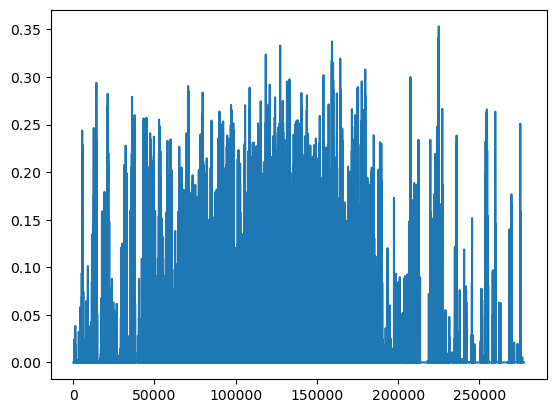

In [8]:
plt.plot(Y_pred)